# Performance Figure
This notebook collects results from different GCN Multi-Omics trainings as well as HotNet2 and MutSigCV. It then shows the performance of all those methods as a scatterplot.
Each method in this plot represents a point and its coordinates represent the performance of it.
The x-axis depicts the performance on the known cancer genes (training + set set for GCN) and the y-axis depicts the performance on the candidate cancer genes from the NCG.

**Different metrics can be chosen to measure the performance. Currently, precision, recall, AUPR and F1 score can be used.**

Metrics:

* Precision measures the fraction of cancer genes out of all genes that were predicted by the algorithm
* Recall measures the fraction of cancer genes that were found (out of all the cancer genes)
* AUPR measures the area under the precision recall curve, so it incorporates both scores

In [1]:
import pandas as pd
import numpy as np
import os, sys
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import gcnIO, postprocessing
sys.path.append(os.path.abspath('../pagerank'))
import pagerank

import matplotlib.pyplot as plt
plt.rc('font', family='Arial')
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
import upsetplot
import seaborn as sns
%matplotlib inline

## Relevant Paths
The 

In [2]:
# get metrics from different multi-omics trainings
dir_multinet = '../data/GCN/training/final_TCGA_all_networks/Multinet/'
dir_cpdb = '../data/GCN/training/final_TCGA_all_networks/CPDB/'
dir_iref = '../data/GCN/training/final_TCGA_all_networks/IRefIndex_old/'
dir_string = '../data/GCN/training/final_TCGA_all_networks/STRING-db/'
dir_irefnew = '../data/GCN/training/final_TCGA_all_networks/IRefIndex/'
dir_pcnet = '../data/GCN/training/final_TCGA_all_networks/PCNet/'

In [3]:
def _get_training_data(training_dir):
    args, data_file = gcnIO.load_hyper_params(training_dir)
    if os.path.isdir(data_file): # FIXME: This is hacky and not guaranteed to work at all!
        network_name = None
        for f in os.listdir(data_file):
            if network_name is None:
                network_name = f.split('_')[0].upper()
            else:
                assert (f.split('_')[0].upper() == network_name)
        fname = '{}_{}.h5'.format(network_name, training_dir.strip('/').split('/')[-1])
        data_file = os.path.join(data_file, fname)
    data = gcnIO.load_hdf_data(data_file)
    return data

def _get_optimal_cutoff(pred, node_names, test_mask, y_test, colname='Mean_Pred'):
    pred_test = pred[pred.Name.isin(node_names[test_mask, 1])]
    y_true = pred_test.label
    y_score = pred_test[colname]
    pr, rec, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_score)
    pr = pr[1:]
    rec = rec[1:]
    thresholds = thresholds[1:]
    distances = np.sqrt(np.sum((np.array([1, 1]) - np.array([rec, pr]).T)**2, axis=1))
    idx = np.argmin(distances)
    best_threshold = thresholds[idx]
    return best_threshold

def _get_predictions(train_dir):
    pred_file = os.path.join(train_dir, 'ensemble_predictions.tsv')
    if os.path.isfile(pred_file):
        pred = pd.read_csv(pred_file, sep='\t')
        return pred
    else:
        return None

def _get_metric_score(pred, node_names, knowns, candidates, cutoff, negatives=None, metric='recall', colname='Mean_Pred'):
    y_knowns = pred.Name.isin(knowns)
    y_candidates = pred.Name.isin(candidates)
    negatives = None
    if not negatives is None: # either use the negatives or not
        y_all_knowns = list(knowns) + list(negatives)
        y_all_cand = list(candidates) + list(negatives)
        y_pred_knowns = pred[pred.Name.isin(y_all_knowns)]
        y_true_knowns = y_knowns[pred.Name.isin(y_all_knowns)]
        y_pred_cand = pred[pred.Name.isin(y_all_cand)]
        y_true_cand = y_candidates[pred.Name.isin(y_all_cand)]
    else:
        y_pred_knowns = pred
        y_true_knowns = y_knowns
        y_pred_cand = pred
        y_true_cand = y_candidates

    if metric.upper() == 'RECALL':
        rec_known = recall_score(y_pred=y_pred_knowns[colname] >= cutoff, y_true=y_true_knowns)
        rec_cand = recall_score(y_pred=y_pred_cand[colname] >= cutoff, y_true=y_true_cand)
        return rec_known, rec_cand
    elif metric.upper() == 'PRECISION':
        prec_known = precision_score(y_pred=y_pred_knowns[colname] >= cutoff, y_true=y_true_knowns)
        prec_cand = precision_score(y_pred=y_pred_cand[colname] >= cutoff, y_true=y_true_cand)
        return prec_known, prec_cand
    elif metric.upper() == 'AUPR':
        aupr_known = average_precision_score(y_score=y_pred_knowns[colname], y_true=y_true_knowns)
        aupr_cand = average_precision_score(y_score=y_pred_cand[colname], y_true=y_true_cand)
        return aupr_known, aupr_cand
    elif metric.upper() == 'F1':
        f1_known = f1_score(y_pred=y_pred_knowns[colname] >= cutoff, y_true=y_true_knowns)
        f1_cand = f1_score(y_pred=y_pred_cand[colname] >= cutoff, y_true=y_true_cand)
        return f1_known, f1_cand
    
def get_metrics_for_training(data_dir, metric='recall', digsee_sets=False, errorbars=False):
    all_metrics = []
    data_types = []
    for d in os.listdir(data_dir):
        training_dir = os.path.join(data_dir, d)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            metrics = get_metrics_for_single_training(training_dir, metric=metric, digsee_sets=digsee_sets, errorbars=errorbars)
            all_metrics.append(metrics)
            data_types.append(d)
    return all_metrics, data_types

def get_metrics_for_single_training(training_dir, metric='recall', digsee_sets=False, errorbars=False):
    if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
        cv_runs = gcnIO.load_hyper_params(training_dir)[0]['cv_runs']
        data = _get_training_data(training_dir)
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        pred = _get_predictions(training_dir)
        cutoff = _get_optimal_cutoff(pred, node_names, test_mask, y_test)
        oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(training_dir)

        if errorbars:
            oncokb_metric = []
            ncg_cand_metric = []
            for run in range(1, cv_runs+1):
                oncokb_local, ncg_cand_local = _get_metric_score(pred, node_names, oncoKB, ncg_cand,
                                                                 cutoff, metric=metric, colname='Prob_pos_{}'.format(run))
                oncokb_metric.append(oncokb_local)
                ncg_cand_metric.append(ncg_cand_local)
        else:
            test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
            genes_negtest = node_names[test_neg, 1] # get the gene names
            oncokb_metric, ncg_cand_metric = _get_metric_score(pred, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
        
        if digsee_sets:
            ds_mut, ds_meth, ds_expr = get_all_digsee_sets(training_dir)
            if errorbars:
                ncg_known_metric = []
                ds_mut_metric = []
                ds_meth_metric = []
                ds_expr_metric = []
                for run in range(1, cv_runs+1):
                    ds_mut_loc, ds_meth_loc = _get_metric_score(pred, node_names, ds_mut, ds_meth, cutoff, None,
                                                                metric, colname='Prob_pos_{}'.format(run))
                    ds_expr_loc, ncg_known_loc = _get_metric_score(pred, node_names, ds_expr, ncg_known, cutoff, None,
                                                                   metric, colname='Prob_pos_{}'.format(run))
                    ncg_known_metric.append(ncg_known_loc)
                    ds_mut_metric.append(ds_mut_loc)
                    ds_meth_metric.append(ds_meth_loc)
                    ds_expr_metric.append(ds_expr_loc)
            else:
                ds_mut_metric, ds_meth_metric = _get_metric_score(pred, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
                ds_expr_metric, ncg_known_metric = _get_metric_score(pred, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
            return ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric
        else:
            return ncg_cand_metric, oncokb_metric

def get_cancer_genes_for_net(model_dir):
    if model_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(model_dir)
    else:
        data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    nodes['label'] = np.logical_or(np.logical_or(y_train, y_test), y_val)
    # to exclude them from other databases
    known_drivers = node_names[np.logical_or(y_train.reshape(-1), y_test.reshape(-1)), 1]
    # get the NCG cancer genes
    known_cancer_genes = []
    candidate_cancer_genes = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                known_cancer_genes.append(l[0])
                candidate_cancer_genes.append(l[1])
            else:
                candidate_cancer_genes.append(l[0])
    known_cancer_genes_innet = nodes[nodes.Name.isin(known_cancer_genes)].Name
    candidate_cancer_genes_innet = nodes[nodes.Name.isin(candidate_cancer_genes)].Name

    oncokb_genes = pd.read_csv('/project/gcn/diseasegcn/data/pancancer/oncoKB/cancerGeneList.txt', sep='\t')
    # remove low confidence genes
    oncokb_no_ncg_highconf = oncokb_genes#[oncokb_genes['OncoKB Annotated'] == 'Yes']
    oncokb_no_ncg_highconf = oncokb_no_ncg_highconf[oncokb_no_ncg_highconf['# of occurrence within resources (Column D-J)'] >= 3]
    # remove all NCG genes
    oncokb_no_ncg = oncokb_no_ncg_highconf[~oncokb_no_ncg_highconf['Hugo Symbol'].isin(known_cancer_genes_innet)]
    candidate_cancer_genes_innet = candidate_cancer_genes_innet[~candidate_cancer_genes_innet.isin(oncokb_no_ncg)]
    #oncokb_no_ncg = oncokb_no_ncg[~oncokb_no_ncg['Hugo Symbol'].isin(candidate_cancer_genes_innet)]
    # remove genes that are not in the network
    oncokb_innet = nodes[nodes.Name.isin(oncokb_no_ncg['Hugo Symbol'])].Name
    
    # comprehensive characterization paper genes
    path = '../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv'
    cancer_genes_paper = pd.read_csv(path, sep='\t', header=3)
    cancer_genes_paper = pd.Series(cancer_genes_paper.Gene.unique())
    cancer_genes_paper_notrain = cancer_genes_paper[~cancer_genes_paper.isin(known_drivers)]
    cancer_genes_paper_innet = nodes[nodes.Name.isin(cancer_genes_paper_notrain)].Name
    #print (cancer_genes_paper.shape, cancer_genes_paper_notrain.shape, cancer_genes_paper_innet.shape)
    
    # driverDB
    driverdb_genes = []
    thresholds_study = {'mutation': 25, 'CNV': 5, 'methylation': 2}
    for evidence in ['mutation', 'CNV', 'methylation']:
        driverdb_data = pd.read_csv('../data/pancancer/driverdb/{}_download_tab.txt'.format(evidence), sep='\t')
        all_driver_genes = []
        for index, row in driverdb_data.iterrows():
            all_driver_genes += [i.strip() for i in row.driver_gene.split(',') if not i.strip() == '']
        study_counts = pd.Series(all_driver_genes).value_counts()
        driverdb_genes += list(study_counts[study_counts > thresholds_study[evidence]].index)
    driverdb_genes = pd.Series(list(set(driverdb_genes)))
    driverdb_genes_notrain = driverdb_genes[~driverdb_genes.isin(known_drivers)]
    driverdb_innet = nodes[nodes.Name.isin(driverdb_genes_notrain)].Name

    # OnGene + TSGene
    oncogenes = pd.read_csv('../data/pancancer/ongene_tsgene/Human_Oncogenes.txt', sep='\t')
    tsgs = pd.read_csv('../data/pancancer/ongene_tsgene/Human_TSGs.txt', sep='\t')
    cancer_genes = list(set(list(oncogenes.OncogeneName) + list(tsgs.GeneSymbol)))
    oncotsgs_innet = nodes[nodes.Name.isin(cancer_genes)].Name
    oncotsgs_innet = oncotsgs_innet[~oncotsgs_innet.isin(known_drivers)]
    oncogenes_innet = oncotsgs_innet[oncotsgs_innet.isin(oncogenes.OncogeneName)]
    tsgs_innet = oncotsgs_innet[oncotsgs_innet.isin(tsgs.GeneSymbol)]
    #print (tsgs_innet.shape, oncogenes_innet.shape, oncotsgs_innet.shape)

    return cancer_genes_paper_innet, candidate_cancer_genes_innet, known_cancer_genes_innet
    #return oncogenes_innet, oncokb_innet, known_cancer_genes_innet


def _get_digsee_genes(base_dir, nodes, to_be_removed, threshold):
    pan_cancer_genes = []
    for f in os.listdir(base_dir):
        if f.startswith('mutation') or f.startswith('expression') or f.startswith('methylation'):
            ctype = f.split('.')[0].split('_')[1]
            fname = os.path.join(base_dir, f)
            evidence = pd.read_csv(fname, sep='\t')
            high_scores = evidence[evidence['EVIDENCE SENTENCE SCORE'] >= threshold]
            pan_cancer_genes += high_scores['GENE SYMBOL'].tolist()
    pan_cancer_genes_filtered = [i for i in pan_cancer_genes if not i in to_be_removed]
    return nodes[nodes.Name.isin(pan_cancer_genes)].Name


def get_all_digsee_sets(train_dir, threshold=0.3):
    if train_dir.endswith('.h5'):
        data = gcnIO.load_hdf_data(train_dir)
    else:
        data = _get_training_data(train_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
    to_be_removed = nodes[np.logical_or(y_train.reshape(-1), y_test.reshape(-1))].Name
    
    expr_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/expression/', nodes, to_be_removed, threshold)
    """
    meth_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/methylation/', nodes, to_be_removed, threshold)
    muta_genes = _get_digsee_genes('/project/gcn/diseasegcn/data/pancancer/digSEE/mutation/', nodes, to_be_removed, threshold)
    """
    
    oncogenes = pd.read_csv('../data/pancancer/ongene_tsgene/Human_Oncogenes.txt', sep='\t')
    oncogenes_innet = nodes[nodes.Name.isin(oncogenes.OncogeneName)].Name
    print (oncogenes_innet.shape, oncogenes.shape)
    oncogenes_final = oncogenes_innet[~oncogenes_innet.isin(to_be_removed)]
    print (oncogenes_final.shape)
    
    path = '../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv'
    bailey = pd.read_csv(path, sep='\t', header=3)
    bailey = pd.Series(bailey.Gene.unique())
    bailey_notrain = bailey[~bailey.isin(to_be_removed)]
    bailey_final = nodes[nodes.Name.isin(bailey_notrain)].Name
    
    return oncogenes_final, bailey_final, expr_genes


def get_metric_for_mutsigcv(model_dir, metric='recall', digsee_sets=False):
    # get the basic data
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # get the MutSigCV scores
    mutsigcv_scores = pd.read_csv('../data/pancancer/mutsigcv/mutsigcv_genescores.csv',
                                  index_col=0, sep='\t').max(axis=1)
    nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    mutsigcv_scores_filled = mutsigcv_scores.reindex(nodes.Name).fillna(0)
    mutsigcv_df = pd.DataFrame(mutsigcv_scores_filled, columns=['Mean_Pred'])
    mutsigcv_df['Name'] = mutsigcv_df.index
    mutsigcv_df['label'] = y_test

    # get sets and compute metrics
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    cutoff = _get_optimal_cutoff(mutsigcv_df, node_names, test_mask, y_test)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = _get_metric_score(mutsigcv_df, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = _get_metric_score(mutsigcv_df, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = _get_metric_score(mutsigcv_df, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        return ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric
    else:
        return ncg_cand_metric, oncokb_metric

def get_hotnet2_results():
    hotnet2_results = {}
    with open('../data/pancancer/hotnet2/hotnet2_results/hotnet2_subnetworks.csv', 'r') as f:
        current_network = None
        current_datatype = None
        all_genes_current = []
        counter = 0
        for line in f.readlines():
            if line.split('\t')[0] in ['HINT+HI2012', 'iRefIndex', 'Multinet']:
                if current_network is None or len(all_genes_current) == 0:
                    pass
                else:
                    hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
                current_network = line.split('\t')[0]
                current_datatype = line.split('\t')[1]
                all_genes_current = []
            if current_network is None:
                continue
            genes = [i.strip() for i in line.split('\t')[2:] if not i in ['', '\n']]
            all_genes_current += genes
        hotnet2_results['{}_{}'.format(current_network, current_datatype)] = list(set(all_genes_current))
    return hotnet2_results

def compute_hotnet2_metrics(metric='recall', digsee_sets=False):
    collected = []
    datatypes = []
    networks = []
    hotnet2_results = get_hotnet2_results()
    for key in hotnet2_results:
        res_df = pd.DataFrame(hotnet2_results[key], columns=['Name'])
        res_df['Mean_Pred'] = 1
        if key.split('_')[0] == 'Multinet':
            data_dir = dir_multinet
            net = 'Multinet'
        elif key.split('_')[0] == 'iRefIndex':
            data_dir = dir_iref
            net = 'IREF'
        else:
            continue
        # load data for the run
        data = _get_training_data(os.path.join(data_dir, 'multiomics'))
        network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
        nodes = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
        res_df_hotnet2 = res_df.set_index('Name').reindex(nodes.Name).fillna(0)
        res_df_hotnet2['Name'] = res_df_hotnet2.index
        
        # get some information on the current run
        datatype = 'Hotnet2 ({} Scores)'.format(key.split('_')[1])
        datatypes.append(datatype)
        networks.append(net)

        oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(data_dir, 'multiomics'))
        test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
        genes_negtest = node_names[test_neg, 1] # get the gene names
        oncokb_metric, ncg_cand_metric = _get_metric_score(res_df_hotnet2, node_names, oncoKB, ncg_cand, 0.5, genes_negtest, metric=metric)
        if digsee_sets:
            ds_mut, ds_meth, ds_expr = get_all_digsee_sets(os.path.join(data_dir, 'multiomics'))
            ds_mut_metric, ds_meth_metric = _get_metric_score(res_df_hotnet2, node_names, ds_mut, ds_meth, 0.5, genes_negtest, metric)
            ds_expr_metric, ncg_known_metric = _get_metric_score(res_df_hotnet2, node_names, ds_expr, ncg_known, 0.5, genes_negtest, metric)
            collected.append([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric])
        else:
            collected.append([ncg_cand_metric, oncokb_metric])

    cols = ['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'] if digsee_sets else ['NCG_Cand', 'OncoKB']
    result = pd.DataFrame(collected, index=datatypes, columns=cols)
    result['Method'] = datatypes
    result['Network'] = networks
    result['ind'] = 'HotNet2'
    result.set_index('ind', inplace=True)
    return result

def compute_RF_metrics(model_dir, network_name, metric='recall', digsee_sets=False):
    # load the data
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    
    # prepare for scikit-learn API
    X_train = features[train_mask.astype(np.bool)]
    y_tr = y_train[train_mask.astype(np.bool)]
    X_test = features[test_mask.astype(np.bool)]

    # train RF classifier
    rf = RandomForestClassifier(n_estimators=100)
    rf.fit(X_train, y_tr.reshape(-1))
    predictions = rf.predict_proba(features)
    predictions = pd.DataFrame(predictions[:, 1], index=node_names[:, 1], columns=['Mean_Pred'])
    predictions['Name'] = predictions.index
    predictions['label'] = y_test
    print (predictions.label.sum(), (predictions.Mean_Pred > 0.5).sum())
    
    cutoff = _get_optimal_cutoff(predictions, node_names, test_mask, y_test)
    print (cutoff)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    oncokb_metric, ncg_cand_metric = _get_metric_score(predictions, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = _get_metric_score(predictions, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = _get_metric_score(predictions, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['RF']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['RF']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'Random Forest'
    return perf_df

def compute_PR_metrics(model_dir, network_name, metric='recall', digsee_sets=False):
    # load the data
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # train pagerank on the network
    scores, names = pagerank.pagerank(network, node_names)
    pr_df = pd.DataFrame(scores, columns=['Number', 'Mean_Pred'])
    # get the results in same order as our data
    names = pd.DataFrame(names, columns=['ID', 'Name'])
    predictions = pr_df.join(names, on='Number', how='inner')
    predictions.drop_duplicates(subset='Name', inplace=True)
    node_names_df = pd.DataFrame(node_names, columns=['ID', 'Name']).set_index('ID')
    predictions = predictions.set_index('Name').reindex(node_names_df.Name)
    predictions['Name'] = predictions.index
    predictions['label'] = y_test

    cutoff = _get_optimal_cutoff(predictions, node_names, test_mask, y_test)
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = _get_metric_score(predictions, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = _get_metric_score(predictions, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = _get_metric_score(predictions, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['PageRank']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['PageRank']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'PageRank'
    return perf_df
    
def compute_netprop_metrics(model_dir, network_name, metric='recall', digsee_sets=False):
    # load the data
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    
    # read heat json from file
    heat_df = pd.read_json('../../hotnet2/heat_syn_cnasnv.json').drop('parameters', axis=1)
    heat_df.dropna(axis=0, inplace=True)

    nn = pd.DataFrame(node_names, columns=['ID', 'Name'])
    heat_df = nn.merge(heat_df, left_on='Name', right_index=True, how='left')
    heat_df.fillna(0, inplace=True)

    # run network propagation
    heat_df['heat_norm'] = heat_df.heat / heat_df.heat.sum()
    #p_0 = heat_df.heat_norm
    p_0 = features[:, :16].mean(axis=1) # mean mutation frequencies
    beta = 0.3
    W = network / network.sum(axis=0) # normalize A
    np.nan_to_num(W, copy=False)
    #assert (np.allclose(W.sum(axis=0), 1)) # assert that rows/cols sum to 1
    p = np.linalg.inv(beta * (np.eye(network.shape[0]) - (1 - beta) * W)).dot(np.array(p_0))
    
    predictions = pd.DataFrame(p, index=node_names[:, 1], columns=['Mean_Pred'])
    predictions['Name'] = predictions.index
    predictions['label'] = y_test
    
    cutoff = _get_optimal_cutoff(predictions, node_names, test_mask, y_test)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    oncokb_metric, ncg_cand_metric = _get_metric_score(predictions, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = _get_metric_score(predictions, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = _get_metric_score(predictions, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['NetProp']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['NetProp']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'Net. Prop. (Mut. Freq.)'
    return perf_df

def compute_deepwalk_metrics(embedding_file, input_file, network_name, metric='recall', digsee_sets=False):
    data = gcnIO.load_hdf_data(input_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # train SVM on deepWalk embeddings
    deepwalk_embeddings = pd.read_csv(embedding_file,
                                      header=None, skiprows=1, sep=' ')

    deepwalk_embeddings.columns = ['Node_Id'] + deepwalk_embeddings.columns[1:].tolist()
    deepwalk_embeddings.set_index('Node_Id', inplace=True)
    n_df = pd.DataFrame(node_names, columns=['ID', 'Name'])
    embedding_with_names = deepwalk_embeddings.join(n_df)
    X_dw = embedding_with_names.set_index('Name').reindex(n_df.Name).drop('ID', axis=1)
    X_train_dw = X_dw[train_mask.astype(np.bool)]
    X_test_dw = X_dw[test_mask.astype(np.bool)]
    clf_dw = SVC(kernel='rbf', class_weight='balanced', probability=True, gamma='auto')
    clf_dw.fit(X_train_dw, y_train[train_mask.astype(np.bool)].reshape(-1))
    pred_deepwalk = clf_dw.predict_proba(X_dw)
    pred_dw_df = pd.DataFrame(pred_deepwalk, columns=['Pred_neg', 'Mean_Pred'], index=X_dw.index).drop('Pred_neg', axis=1)
    pred_dw_df['Name'] = pred_dw_df.index
    pred_dw_df['label'] = y_test
    cutoff = _get_optimal_cutoff(pred_dw_df, node_names, test_mask, y_test)

    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(input_file)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = _get_metric_score(pred_dw_df, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(input_file)
        ds_mut_metric, ds_meth_metric = _get_metric_score(pred_dw_df, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = _get_metric_score(pred_dw_df, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['DeepWalk']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['DeepWalk']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'DeepWalk + SVM'
    return perf_df

def compute_gat_metrics(gat_result_file, gat_input_file, network_name, metric='recall', digsee_sets=False):
    gat_results = np.load(gat_result_file)
    gat_results = gat_results.reshape(gat_results.shape[1], gat_results.shape[2])
    data = gcnIO.load_hdf_data(gat_input_file)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    pred = pd.DataFrame(node_names, columns=['ID', 'Name'])
    pred['Mean_Pred'] = gat_results[:, 1] # assuming same order
    pred['label'] = y_test
    cutoff = _get_optimal_cutoff(pred, node_names, test_mask, y_test)
    
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(gat_input_file)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = _get_metric_score(pred, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric=metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(gat_input_file)
        ds_mut_metric, ds_meth_metric = _get_metric_score(pred, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = _get_metric_score(pred, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        perf_df = pd.DataFrame([ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric],
                               index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'],
                               columns=['GAT']).T
    else:
        perf_df = pd.DataFrame([ncg_cand_metric, oncokb_metric],
                               index=['NCG_Cand', 'OncoKB'],
                               columns=['GAT']).T
    perf_df['Network'] = network_name
    perf_df['Method'] = 'GAT'
    return perf_df

def compute_degree_metrics(model_dir, metric='recall', digsee_sets=False):
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    score = pd.DataFrame(network.sum(axis=1), index=node_names[:, 1], columns=['Mean_Pred'])
    score['label'] = y_test
    score['Name'] = score.index

    # get sets and compute metrics
    oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(model_dir)
    cutoff = _get_optimal_cutoff(score, node_names, test_mask, y_test)
    test_neg = np.logical_and(np.logical_not(y_test.reshape(-1)), test_mask) # negatives for testing
    genes_negtest = node_names[test_neg, 1] # get the gene names
    oncokb_metric, ncg_cand_metric = _get_metric_score(score, node_names, oncoKB, ncg_cand, cutoff, genes_negtest, metric)
    if digsee_sets:
        ds_mut, ds_meth, ds_expr = get_all_digsee_sets(model_dir)
        ds_mut_metric, ds_meth_metric = _get_metric_score(score, node_names, ds_mut, ds_meth, cutoff, genes_negtest, metric)
        ds_expr_metric, ncg_known_metric = _get_metric_score(score, node_names, ds_expr, ncg_known, cutoff, genes_negtest, metric)
        return ncg_known_metric, ncg_cand_metric, oncokb_metric, ds_mut_metric, ds_meth_metric, ds_expr_metric
    else:
        return ncg_cand_metric, oncokb_metric

## Overlap of Gene Sets

In [4]:
cancer_gene_sets = postprocessing.get_all_cancer_gene_sets(ncg_path='../data/pancancer/NCG/cancergenes_list.txt',
                                                           oncoKB_path='../data/pancancer/oncoKB/cancerGeneList.txt',
                                                           baileyetal_path='../data/pancancer/comprehensive_characterization_of_cancer_driver_genes_and_mutations/comprehensive_characterization_cancer_genes.csv',
                                                           ongene_path='../data/pancancer/ongene_tsgene/Human_Oncogenes.txt'
                                                          )
ncg_knowns = cancer_gene_sets[0]
ncg_candidates = cancer_gene_sets[1]
oncoKB_genes = cancer_gene_sets[2]
baileyetal = cancer_gene_sets[3]
oncogenes = cancer_gene_sets[4]

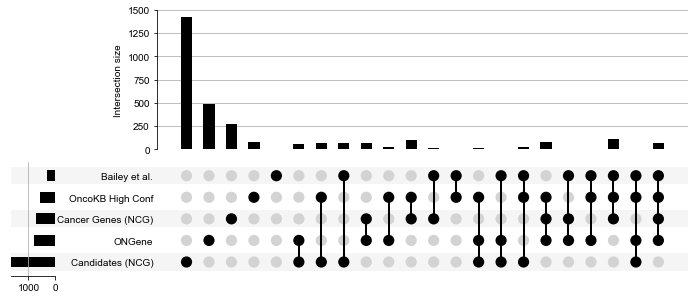

In [5]:
fig = plt.figure(figsize=(30, 20))
cancer_gene_set_dict = {#'DriverDB': list(driverdb_genes),
                        'ONGene': list(oncogenes),
                        #'TSGene': list(tsgs.GeneSymbol),
                        'Cancer Genes (NCG)': ncg_knowns,
                        'Candidates (NCG)': ncg_candidates,
                        'Bailey et al.': baileyetal,
                        'OncoKB High Conf': oncoKB_genes
                        #'COSMIC CGC': cgc
                       }
contents = upsetplot.from_contents(cancer_gene_set_dict)
_ = upsetplot.plot(contents, subset_size='auto', fig=fig)
#fig.savefig('../data/pancancer/overlap_independent_cancergenesets.svg')

## Joint Performance for All Tools on Test Set

In [6]:
training_runs = {'Multinet': dir_multinet,
                 'CPDB': dir_cpdb,
                 'IREF':dir_iref,
                 'STRING-db': dir_string,
                 'IREF (New)': dir_irefnew,
                 'PCNet': dir_pcnet
                }
name2ppiname = {'Multinet': 'Multinet', 'CPDB': 'CPDB', 'IREF': 'IREF', 'IREF (New)': 'IREFNew', 'STRING-db': 'string', 'PCNet': 'PCNet'}
methods = [('EMOGI', 'EMOGI'), ('Random Forest', 'Random_Forest'),
           ('DeepWalk + SVM', 'DeepWalk'),
           ('PageRank', 'PageRank'), ('Net. Prop.', 'RWR'),
           ('MutSigCV', 'MutSigCV')]
ppi_networks = ['CPDB', 'IREF (New)', 'STRING-db', 'Multinet', 'PCNet', 'IREF']
aupr_all = pd.DataFrame(index=[m[0] for m in methods])

for ppi_network in ppi_networks:
    performance_all, performance_test = postprocessing.compute_predictions_competitors(model_dir=os.path.join(training_runs[ppi_network], 'multiomics'),
                                                                                   network_name=name2ppiname[ppi_network], network_measures=False,
                                                                                   plot_correlations=False, verbose=True)
    
    data = _get_training_data(os.path.join(training_runs[ppi_network], 'multiomics'))
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    # compute area under PR curve
    aupr_values = []
    for name, colname in methods:
        aupr = average_precision_score(y_true=y_test[test_mask == 1, 0], y_score=performance_test[colname])
        aupr_values.append(aupr)
    print ("Computations for {} completed!".format(ppi_network))
    aupr_all[ppi_network] = aupr_values
    
    if ppi_network == 'CPDB':
        performance_cpdb = performance_all

aupr_all.columns = ['IRefIndex\n(2015)' if i == 'IREF' else i for i in aupr_all.columns]
aupr_all.columns = ['IRefIndex' if i == 'IREF (New)' else i for i in aupr_all.columns]

Number of predicted genes in Test set (RF): 77
RF predicts 1687 genes in total
Number of predicted genes in Test set (LogReg): 263
LogReg predicts 5430 genes in total


/project/gcn/diseasegcn/GCN/postprocessing.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for CPDB completed!
Number of predicted genes in Test set (RF): 32
RF predicts 1073 genes in total
Number of predicted genes in Test set (LogReg): 395
LogReg predicts 6775 genes in total


/project/gcn/diseasegcn/GCN/postprocessing.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for IREF (New) completed!
Number of predicted genes in Test set (RF): 87
RF predicts 1950 genes in total
Number of predicted genes in Test set (LogReg): 297
LogReg predicts 5829 genes in total


/project/gcn/diseasegcn/GCN/postprocessing.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for STRING-db completed!
Number of predicted genes in Test set (RF): 81
RF predicts 1732 genes in total
Number of predicted genes in Test set (LogReg): 340
LogReg predicts 6566 genes in total


/project/gcn/diseasegcn/GCN/postprocessing.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for Multinet completed!
Number of predicted genes in Test set (RF): 33
RF predicts 1048 genes in total
Number of predicted genes in Test set (LogReg): 468
LogReg predicts 7786 genes in total


/project/gcn/diseasegcn/GCN/postprocessing.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for PCNet completed!
Number of predicted genes in Test set (RF): 106
RF predicts 2129 genes in total
Number of predicted genes in Test set (LogReg): 245
LogReg predicts 5024 genes in total


/project/gcn/diseasegcn/GCN/postprocessing.py:455: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  pr_pred_test.drop_duplicates(inplace=True)


Computations for IREF completed!


In [7]:
aupr_all.columns = ['IRefIndex\n(2015)' if i == 'IRefIndex (2015)' else i for i in aupr_all.columns]

In [8]:
aupr_all

,CPDB,IRefIndex,STRING-db,Multinet,PCNet,IRefIndex (2015)
EMOGI,0.706,0.597,0.704,0.681,0.656,0.725
Random Forest,0.531,0.513,0.566,0.569,0.478,0.602
DeepWalk + SVM,0.726,0.541,0.682,0.508,0.631,0.659
PageRank,0.594,0.466,0.519,0.531,0.536,0.620
Net. Prop.,0.623,0.493,0.550,0.562,0.478,0.647
MutSigCV,0.380,0.293,0.389,0.325,0.271,0.430


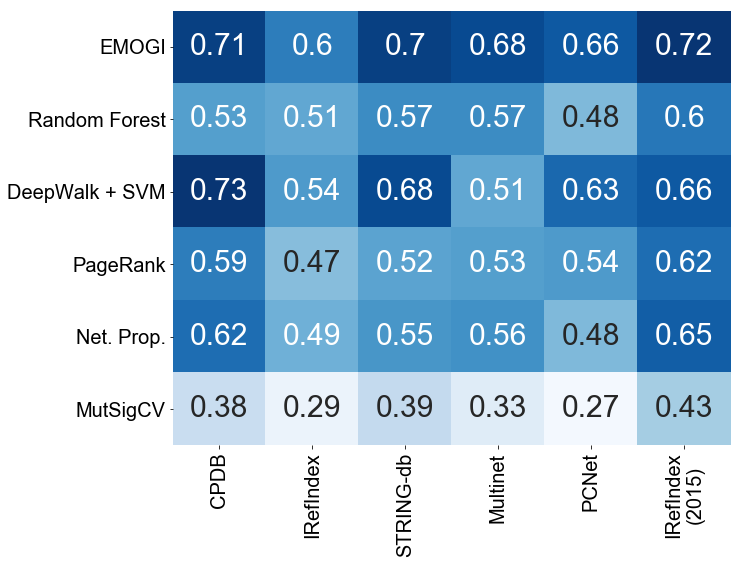

In [9]:
fig = plt.figure(figsize=(10, 8))
#cmap = sns.light_palette((240, 85, 50), input="husl", n_colors=50)#sns.color_palette("Blues")
cmap = sns.color_palette("Blues", n_colors=50)
sns.heatmap(aupr_all, cbar=False, cmap=cmap, cbar_kws={'use_gridspec': False, 'orientation': 'vertical'},
            annot=True, annot_kws={"size": 30, 'weight': 'medium'})
_ = plt.gca().set_xticklabels(aupr_all.columns, rotation=90, fontsize=20)
_ = plt.gca().set_yticklabels(aupr_all.index, rotation=0, fontsize=20)
tool_colors = ["darkred", "darkorange", "darkgreen", "darkblue", "grey", "purple"]
#[t.set_color(c) for (c,t) in zip(tool_colors, plt.gca().yaxis.get_ticklabels())]
fig.savefig('/project/gcn/diseasegcn/data/GCN/training/final_TCGA_all_networks/aupr_heatmap.svg',
            bbox_inches='tight')

## Overlap of Predictions from Different Tools

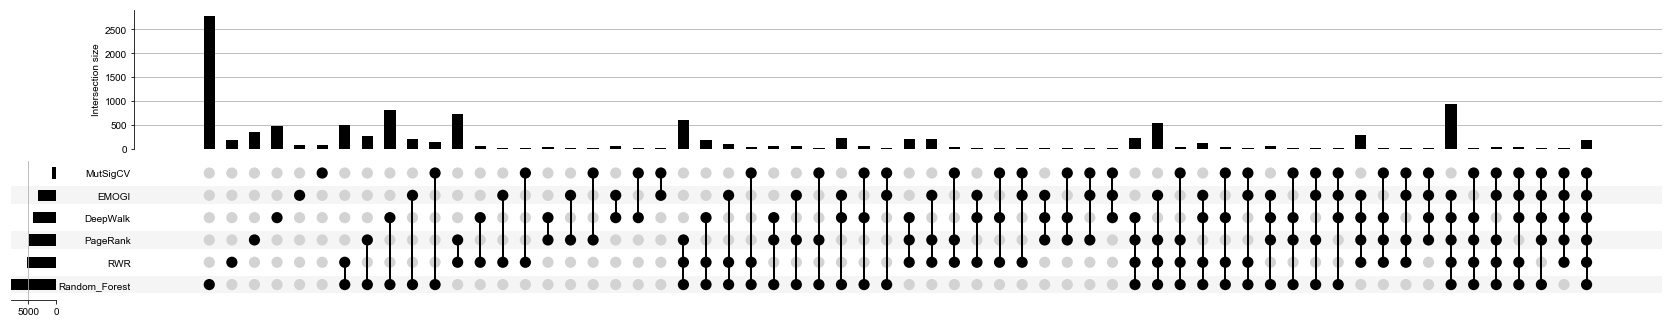

In [12]:
# 1. load data and compute cutoffs for all tools
model_dir = os.path.join(dir_cpdb, 'multiomics')
data = _get_training_data(model_dir)
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
performance_cpdb['Name'] = performance_cpdb.index # needed for cutoff computation
performance_cpdb['label'] = y_test

all_cutoffs = {}
for col in performance_cpdb.drop(['ID', 'Name', 'label'], axis=1).columns:
    cutoff = _get_optimal_cutoff(performance_cpdb, node_names, test_mask, y_test, colname=col)
    all_cutoffs[col] = cutoff

# 2. compute positive sets for all tools
pos_predicted = {}
for col in performance_cpdb.drop(['ID', 'Name', 'label'], axis=1).columns:
    pos_pred = performance_cpdb[col] >= all_cutoffs[col]
    pos_predicted[col] = list(performance_cpdb[pos_pred].Name)

# 3. compute and display overlaps between all tools
plot_input = upsetplot.from_contents(pos_predicted)
fig = plt.figure(figsize=(20, 15))
upsetplot.plot(plot_input, subset_size='auto', fig=fig)
fig.savefig(os.path.join(model_dir, 'overlap_tool_prediction.svg'))

## Compute Test Set Performance for Single and Dual Omics

In [70]:
network_of_interest = 'CPDB'

all_aupr_single_omics = []
for ppi_network in ppi_networks:
    metrics_single_omics = {}
    for omics_subset in os.listdir(training_runs[ppi_network]):
        training_dir = os.path.join(training_runs[ppi_network], omics_subset)
        if os.path.isdir(training_dir) and os.path.isfile(os.path.join(training_dir, 'hyper_params.txt')):
            data = _get_training_data(training_dir)
            network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
            pred = postprocessing.load_predictions(training_dir)
            cutoff = _get_optimal_cutoff(pred, node_names, test_mask, y_test, colname='Prob_pos')
            #pred = pred[y_test]
            neg_pred = pred[pred.Prob_pos < cutoff]
            print (neg_pred.label.sum(), neg_pred.shape[0])
            metrics_single_omics[omics_subset] = [neg_pred.label.sum(), neg_pred.shape[0]]
    metrics_df = pd.DataFrame(metrics_single_omics)
    all_aupr_single_omics.append(metrics_df)
    print ("Computed for {}".format(ppi_network))
    #break

207 8908
281 10150
145 8423
157 9581
171 9765
252 10343
177 10395
Computed for CPDB
185 12880
323 13251
341 13167
378 13653
265 12911
348 14473
293 13756
Computed for IREF (New)
215 8473
295 9334
237 9569
219 9938
71 7582
164 8835
103 9291
Computed for STRING-db
193 9549
182 9448
153 9329
202 10762
175 10746
158 9613
105 9271
Computed for Multinet
197 13733
189 12872
255 14200
204 14352
200 14146
221 14742
193 14442
Computed for PCNet
215 7930
195 7592
138 7352
197 8714
160 8282
174 8067
131 8363
Computed for IREF


Text(0, 0.5, 'Number of Missed Known Cancer Genes')

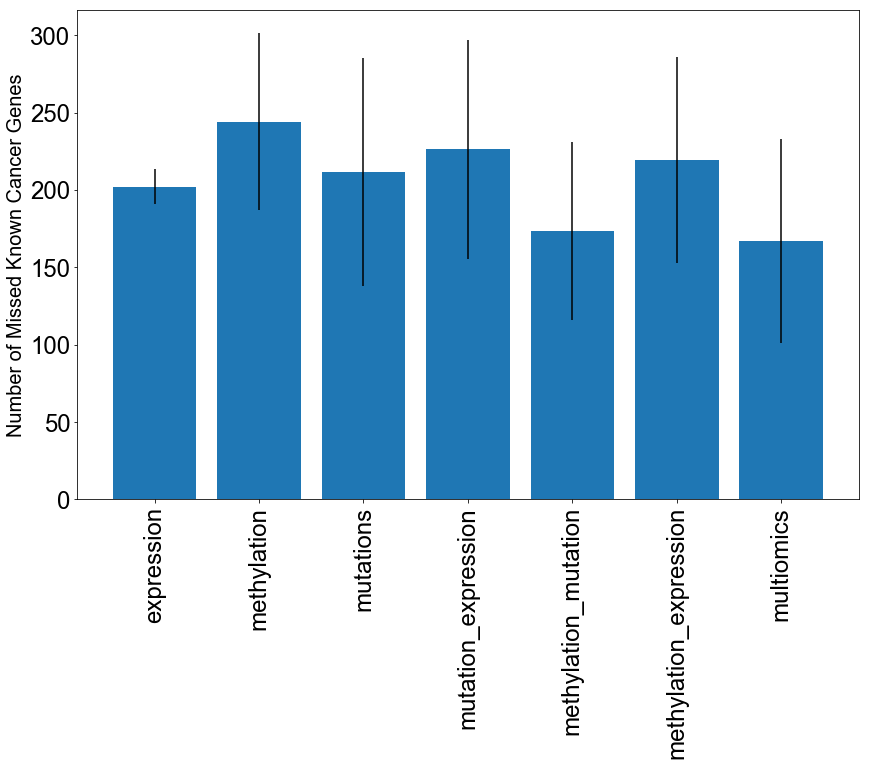

In [82]:
avg_misses = []
for net in all_aupr_single_omics:
    test = net.T
    test.columns = ['Num_Cancer_Genes', 'Num_Predictions']
    avg_misses.append(test.Num_Cancer_Genes)

std_misses = np.std(avg_misses, axis=0)
avg_misses = np.mean(avg_misses, axis=0)

fig = plt.figure(figsize=(14, 9))
ax = plt.bar(x=list(range(avg_misses.shape[0])), height=avg_misses, yerr=std_misses)
_ = plt.xticks(list(range(avg_misses.shape[0])), labels=test.index, rotation=90, fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Number of Missed Known Cancer Genes', fontsize=20)

In [52]:
for i in range(len(all_aupr_single_omics)):
    all_aupr_single_omics[i]['Network'] = ppi_networks[i]

single_omics_metrics_df = pd.concat(all_aupr_single_omics)
fig = plt.figure(figsize=(14, 9))
sns.barplot(data=single_omics_metrics_df.melt(id_vars=['Network']), x='Network', y='value', hue='variable')

ValueError: No objects to concatenate

## Prediction Performance for Single (and Dual) Omics Data

In [ ]:
metric_of_choice = 'aupr'
gcn_training_path = dir_cpdb
used_network = 'CPDB'
reference = 'multiomics' # the reference training to use for the competing methods

# get metrics for GCN
gcn_all = get_metrics_for_training(gcn_training_path, metric=metric_of_choice,
                                   digsee_sets=True, errorbars=True)
gcn_all_array = np.array(gcn_all[0])
flattened_dfs = []
for cv_run in range(gcn_all_array.shape[-1]):
    df = pd.DataFrame(gcn_all_array[:, :, cv_run], index=gcn_all[1],
                      columns=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr'])
    df['cv'] = cv_run
    flattened_dfs.append(df)
gcn_metrics = pd.concat(flattened_dfs)
gcn_metrics['Network'] = used_network
gcn_metrics['Method'] = gcn_metrics.index

# get metrics for GAT
gat_m = compute_gat_metrics('../data/pancancer/gat_results/results_GAT_{}.npy'.format(used_network.upper()),
                            gcnIO.load_hyper_params(os.path.join(gcn_training_path, reference))[1], used_network,
                            metric_of_choice, digsee_sets=True)

# get metrics for HotNet2
hn2_m = compute_hotnet2_metrics(metric=metric_of_choice, digsee_sets=True)

# get metrics for DeepWalk + SVM
dw_m = compute_deepwalk_metrics('../data/pancancer/deepWalk_results/{}_embedding_CPDBparams.embedding'.format(used_network.upper()),
                                gcnIO.load_hyper_params(os.path.join(gcn_training_path, reference))[1], used_network,
                                metric=metric_of_choice, digsee_sets=True)

# get metrics for MutSigCV
mscv_m = get_metric_for_mutsigcv(os.path.join(gcn_training_path, reference),
                                 metric=metric_of_choice, digsee_sets=True)
mscv_df = pd.DataFrame(mscv_m, columns=['MutSigCV'],
                       index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr']).T

# get metrics for node degree
nd_m = compute_degree_metrics(os.path.join(dir_cpdb, reference), metric='aupr', digsee_sets=True)
nd_df = pd.DataFrame(nd_m, columns=['Node Degree'],
                     index=['NCG_Known', 'NCG_Cand', 'OncoKB', 'DS_Mut', 'DS_Meth', 'DS_Expr']).T

digsee_metrics_competitors = pd.concat((gcn_metrics, gat_m, dw_m, hn2_m, mscv_df, nd_df))

# get random metrics
def _get_random_metric(model_dir, dataset, metric='recall'):
    data = _get_training_data(model_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    if metric.upper() == 'AUPR' or metric.upper() == 'PRECISION':
        random_performance = len(dataset) / network.shape[0]
    elif metric.upper() == 'RECALL':
        return 0.5 # assuming that the classifier has probability of 0.5 to predict positive
    elif metric.upper() == 'F1':
        rand_precision = len(dataset) / network.shape[0]
        rand_recall = 0.5
        random_performance = 2 * ( (rand_precision*rand_recall) / (rand_precision + rand_recall) )
    else:
        print ("Metric {} not understood".format(metric))
    return random_performance

ds_sets = get_all_digsee_sets(os.path.join(gcn_training_path, reference))
rand_perfs = {}
count = 0
for i in ['Oncogenes\n(ONGene)', 'Bailey et al.\n(2018)', 'DigSee Expr.\nGenes']:#['DigSEE Mutation\nGenes', 'DigSEE Meth.\nGenes', 'DigSee Expr.\nGenes']:
    rand_perfs[i] = _get_random_metric(os.path.join(gcn_training_path, reference),
                                       ds_sets[count], metric=metric_of_choice)
    count += 1
onco, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(gcn_training_path, reference))
rand_perfs['NCG Known\nCancer Genes'] = _get_random_metric(os.path.join(gcn_training_path, reference), ncg_known, metric=metric_of_choice)
rand_perfs['NCG Candidate\nCancer Genes'] = _get_random_metric(os.path.join(gcn_training_path, reference), ncg_cand, metric=metric_of_choice)
rand_perfs['OncoKB Genes\n(not in NCG)'] = _get_random_metric(os.path.join(gcn_training_path, reference), onco, metric=metric_of_choice)

In [ ]:
fig = plt.figure(figsize=(14, 9))
replace_dict = {'expression': 'Gene Expression', 'methylation': 'DNA Methylation',
                'mutations': 'Mutation Freq.', 'multiomics': 'Multi-Omics',
                'mutation_expression': 'Mutations & Expression',
                'methylation_expression': 'DNA Meth. & Expression',
                'methylation_mutation': 'DNA Meth. & Mutations.',
                'no_cna': 'No Copy Number', 'no_ge': 'No Gene Expr.',
                'no_meth': 'No DNA Meth.', 'no_snvs': 'No Mutation'
               }
col_replace_dict = {'DS_Expr': 'DigSee Expr.\nGenes', #'DS_Meth': 'DigSEE Meth.\nGenes', 'DS_Mut': 'DigSEE Mutation\nGenes',
                    'NCG_Known': 'NCG Known\nCancer Genes',
                    'NCG_Cand': 'NCG Candidate\nCancer Genes', 'OncoKB': 'OncoKB Genes\n(not in NCG)',
                    'DS_Mut': 'Oncogenes\n(ONGene)', 'DS_Meth': 'Bailey et al.\n(2018)'
                   }
gcn_metrics_copy = gcn_metrics.copy().drop('DS_Expr', axis=1)
gcn_metrics_copy.rename(mapper=col_replace_dict, axis=1, inplace=True)
metrics_melted = gcn_metrics_copy.drop('Network', axis=1).melt(id_vars=['Method', 'cv'])
metrics_melted.Method = metrics_melted.Method.replace(replace_dict)
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui) + sns.xkcd_palette(["dark orange", "windows blue", "amber", "faded green",
                                                       "dusty purple", "light blue",  "black", "light green", "dark blue", "pink", "light yellow"])

p = sns.barplot(data=metrics_melted, x='variable', y='value', hue='Method', palette=colors)
#_ = sns.swarmplot(data=metrics_melted, x='variable', y='value', hue='Method')

group = 0
for group_name in metrics_melted.variable.unique():
    print (group_name)
    plt.plot([group-0.4, group+0.4], [rand_perfs[group_name], rand_perfs[group_name]],
             ls='--', lw=5, alpha=.7, c='black')
    group += 1

rand_handle = Line2D([0], [0], color='black', linewidth=3, linestyle='--')
handles, labels = plt.gca().get_legend_handles_labels()
handles.append(rand_handle)
labels.append('Random')

plt.ylabel('{}'.format(metric_of_choice.upper()), fontsize=20)
plt.yticks(fontsize=16)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=16)
legend = plt.legend(loc='upper center', borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5, handles=handles, labels=labels)
#legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
#                    markerscale=2.5, handles=handles, labels=labels)
#fig.savefig(os.path.join(gcn_training_path, '{}_singleomics_candidates_oncokb_ongene_bailey.svg'.format(metric_of_choice)), bbox_inches='tight')

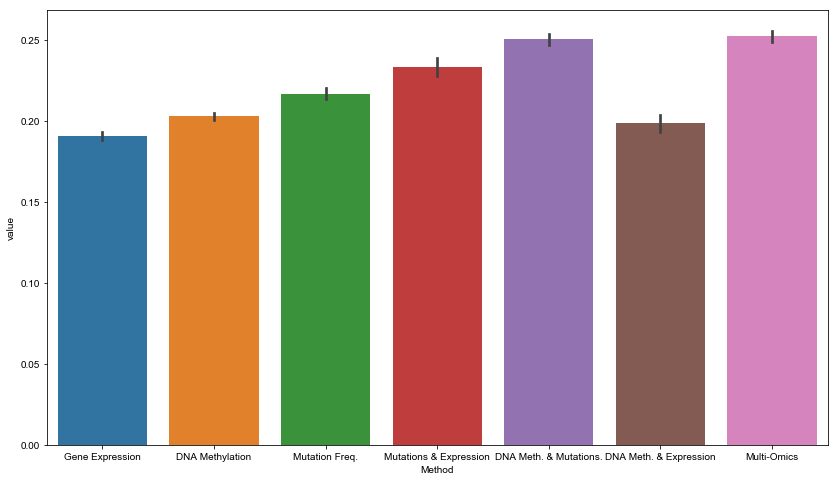

In [90]:
metrics_melted = metrics_melted[metrics_melted.variable == 'NCG Known\nCancer Genes']
fig = plt.figure(figsize=(14, 8))
sns.barplot(data=metrics_melted, y='value', x='Method')

## Plot Performance for Independent Data Sets

In [7]:
metric_of_choice = 'recall'

training_runs = {'Multinet': dir_multinet,
                 'CPDB': dir_cpdb,
                 'IREF':dir_iref,
                 'STRING-db': dir_string,
                 'IREF (New)': dir_irefnew,
                 'PCNet': dir_pcnet
                }
all_metrics = []
for network_name in training_runs:
    print (network_name)
    metrics, omics = get_metrics_for_training(training_runs[network_name], metric=metric_of_choice, digsee_sets=False)
    x = pd.DataFrame(metrics, index=omics,
                     columns=['NCG_Cand', 'OncoKB'])
    x['Network'] = network_name
    all_metrics.append(x)
all_metrics_df = pd.concat(all_metrics)
all_metrics_df['Method'] = all_metrics_df.index

# get mutsigcv metrics
print ("Loading MutSigCV performance")
mutsigcv_perf = []
for network_name, network_dir in {'Multinet': dir_multinet, 'CPDB': dir_cpdb, 'IREF':dir_iref}.items():
    ms_perf_known, ms_perf_cand = get_metric_for_mutsigcv(os.path.join(network_dir, 'multiomics'), metric=metric_of_choice)
    mutsigcv_perf.append([ms_perf_known, ms_perf_cand, network_name])
mutsig_perf_df = pd.DataFrame(mutsigcv_perf, columns=['NCG_Cand', 'OncoKB', 'Network'])
mutsig_perf_df['Method'] = 'MutSigCV'
mutsig_perf_df.set_index('Method', inplace=True)
mutsig_perf_df['Method'] = 'MutSigCV'

# compute metrics for HotNet2 results
print ("Computing HotNet2 metrics")
hotnet2_perf = compute_hotnet2_metrics(metric=metric_of_choice)

# compute metrics for deepwalk
print ("Computing DeepWalk metrics")
dw_resdir = '../data/pancancer/deepWalk_results/'
input_basedir = '../data/pancancer/'
dw_paths = {'IREF': ('IREF_embedding_CPDBparams.embedding', 'multiomics_containers/IREF_multiomics.h5'),
            'Multinet': ('MULTINET_embedding_CPDBparams.embedding', 'all_omics_multinet/MULTINET_multiomics.h5'),
            'CPDB': ('CPDB_embedding_CPDBparams.embedding', 'CPDB_multiomics_omimallneg.h5'),
            'STRING-db':('STRING_embedding_CPDBparams.embedding', 'all_omics_final_STRING/STRING_multiomics.h5'),
            'IREF (New)': ('IREFNEW_embedding_CPDBparams.embedding', 'all_omics_final_IREFNew/IREFNew_multiomics.h5'),
            'PCNet': ('PCNET_embedding_CPDBparams.embedding', 'all_omics_final_PCNET/PCNET_multiomics.h5')
           }
dw_dfs = []
for key in dw_paths:
    res, inp = dw_paths[key]
    dw_dfs.append(compute_deepwalk_metrics(os.path.join(dw_resdir, res),
                                           os.path.join(input_basedir, inp),
                                           network_name=key,
                                           metric=metric_of_choice)
                  )
dw_perf = pd.concat((dw_dfs))

# compute metrics for PageRank
print ("Computing PageRank metrics")
pr_metrics = []
for network_name in training_runs:
    pr_metrics.append(compute_PR_metrics(model_dir=os.path.join(training_runs[network_name], 'multiomics'),
                                         network_name=network_name,
                                         metric=metric_of_choice,
                                         digsee_sets=False
                                        )
                     )
pr_perf = pd.concat(pr_metrics)

# compute metrics for random forest
print ("Computing RandomForest metrics")
rf_metrics = []
for network_name in training_runs:
    rf_metrics.append(compute_RF_metrics(model_dir=os.path.join(training_runs[network_name], 'multiomics'),
                                         network_name=network_name,
                                         metric=metric_of_choice,
                                         digsee_sets=False
                                        )
                     )
rf_perf = pd.concat(rf_metrics)


# compute metrics for network propagation
print ("Computing Network propagation metrics")
netprop_metrics = []
for network_name in training_runs:
    netprop_metrics.append(compute_netprop_metrics(model_dir=os.path.join(training_runs[network_name], 'multiomics'),
                                         network_name=network_name,
                                         metric=metric_of_choice,
                                         digsee_sets=False
                                        )
                     )
netprop_perf = pd.concat(netprop_metrics)

# compute metrics for GAT
"""
print ("Computing GAT metrics")
gat_resdir = '../data/pancancer/gat_results/'
input_basedir = '../data/pancancer/'
gat_paths = {'IREF': ('results_GAT_IREF.npy', 'multiomics_containers/IREF_multiomics.h5'),
             'Multinet': ('results_GAT_MULTINET.npy', 'all_omics_multinet/MULTINET_multiomics.h5'),
             'CPDB': ('results_GAT_CPDB.npy', 'all_omics_final_CPDB/CPDB_multiomics.h5'),
             'IREF (New)': ('results_GAT_IREFNEW.npy', 'all_omics_final_IREFNew/IREFNew_multiomics.h5'),
             'STRING-db': ('results_GAT_STRING.npy', 'all_omics_final_STRING/STRING_multiomics.h5'),
             'PCNet': ('results_GAT_PCNET.npy', 'all_omics_final_PCNET/PCNET_multiomics.h5')
            }
gat_dfs = []
for key in gat_paths:
    res, inp = gat_paths[key]
    gat_dfs.append(compute_gat_metrics(os.path.join(gat_resdir, res),
                                       os.path.join(input_basedir, inp),
                                       network_name=key,
                                       metric=metric_of_choice)
                  )
gat_perf = pd.concat((gat_dfs))
"""

all_metrics_df = pd.concat((all_metrics_df, mutsig_perf_df, hotnet2_perf, dw_perf, pr_perf, rf_perf, netprop_perf))

Multinet
CPDB
IREF
STRING-db
IREF (New)
PCNet
Loading MutSigCV performance
Computing HotNet2 metrics
Computing DeepWalk metrics
Computing PageRank metrics
Computing RandomForest metrics
198 1669
0.23
199 1638
0.3
196 1981
0.33
196 1955
0.36
210 1147
0.21
215 1059
0.23
Computing Network propagation metrics


/home/sasse/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:117: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [60]:
"""
metric_cand_new, metric_known_new = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_07_18_14_58_23/', metric=metric_of_choice)
add_dict = {'NCG_Cand': metric_cand_new, 'OncoKB': metric_known_new, 'Method': 'GCN (Multi-Omics Reprod_old)', 'Network': 'IREF'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)

#metric_cand_new, metric_known_new = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_07_23_12_15_00', metric=metric_of_choice)
#add_dict = {'Candidate Cancer Genes': metric_cand_new, 'Known Cancer Genes': metric_known_new, 'Method': 'GCN (Multi-Omics DigSEE + NCG Labels)', 'Network': 'IREF'}
#all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)

metric_cand_new, metric_known_new = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_07_19_13_11_28/', metric=metric_of_choice)
add_dict = {'NCG_Cand': metric_cand_new, 'OncoKB': metric_known_new, 'Method': 'GCN (Multi-Omics Reprod_old)', 'Network': 'IREF (SNV+CNA)'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)

metric_cand_new, metric_known_new = get_metrics_for_single_training('/project/gcn/diseasegcn/data/GCN/training/2019_07_19_12_54_50/', metric=metric_of_choice)
add_dict = {'NCG_Cand': metric_cand_new, 'OncoKB': metric_known_new, 'Method': 'GCN (Multi-Omics Old Negatives)', 'Network': 'IREF'}
all_metrics_df = all_metrics_df.append(add_dict, ignore_index=True)

metric_cand_new, metric_onco_new = get_metrics_for_single_training('../data/GCN/training/2019_10_29_17_26_02/', metric=metric_of_choice)
add_dict = {'NCG_Cand': metric_cand_new, 'OncoKB': metric_onco_new, 'Method': 'GCN (simpleCNA)', 'Network': 'CPDB'}
all_metrics_df = all_metrics_df.append(pd.Series(add_dict, name='GCN_reprod'), ignore_index=False)
"""
print ()

In [8]:
all_metrics_df.groupby('Method').mean()

,NCG_Cand,OncoKB
Method,,
DeepWalk + SVM,0.447,0.679
Hotnet2 (Frequency Scores),0.065,0.059
Hotnet2 (MutSig Scores),0.004,0.037
MutSigCV,0.109,0.454
Net. Prop. (Mut. Freq.),0.431,0.689
PageRank,0.429,0.687
Random Forest,0.699,0.802
expression,0.430,0.705
methylation,0.398,0.600


8 6


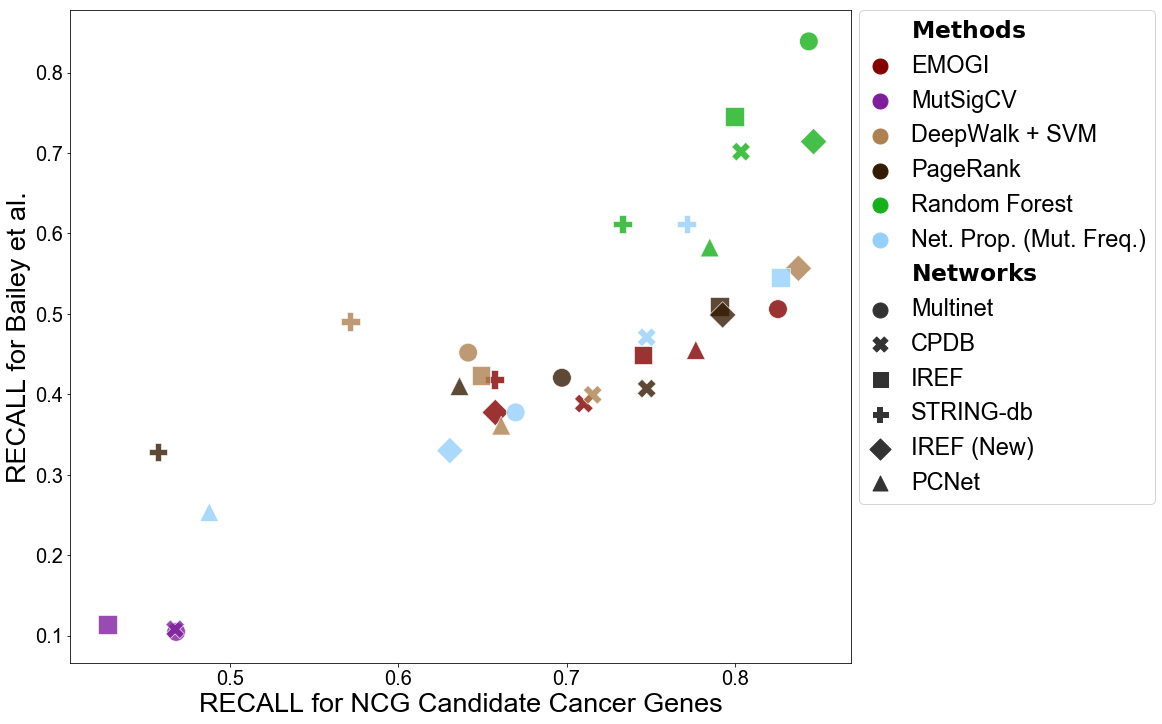

In [10]:
fig = plt.figure(figsize=(14, 12))
replace_dict = {'expression': 'EMOGI (Expression only)', 'methylation': 'EMOGI (Methylation only)',
                'mutations': 'EMOGI (Mutation Frequency only)', 'multiomics': 'EMOGI',
                'mutation_expression': 'EMOGI (No Methylation)',
                'methylation_expression': 'EMOGI (No Mutation)',
                'methylation_mutation': 'EMOGI (No Expression)',
                'no_cna': 'EMOGI (No CNA)', 'no_ge': 'EMOGI (No Expression)',
                'no_meth': 'EMOGI (No Methylation)', 'no_snvs': 'EMOGI (No Mutation)'
               }

network_names = {'IREF': 'IRefIndex (2015)', 'IREF (NEW)': 'IRefIndex'}

all_metrics_df_relevant = all_metrics_df[all_metrics_df.index.isin(['multiomics',#'no_snvs', 'no_cna',
                                                                     #'expression_mutation', 'mutations',
                                                                     'MutSigCV', 'DeepWalk', 'PageRank', 'RF', 'NetProp'])]

all_metrics_df.Method = all_metrics_df.Method.replace(replace_dict)
all_metrics_df_relevant.Method = all_metrics_df_relevant.Method.replace(replace_dict)
"""
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
colors = sns.color_palette(flatui) + sns.xkcd_palette(["dark orange", "windows blue", "amber", "faded green",
                                                       "dusty purple", "light blue",  "black", "light green", "dark blue", "pink", "light yellow"])
"""
colors = sns.xkcd_palette(["dark red", "purple", "light brown", "dark brown", "green", "light blue", "pink", 'grey'])
print (len(colors), all_metrics_df_relevant.Method.nunique())

sns.scatterplot(data=all_metrics_df_relevant,
                x='OncoKB',
                y='NCG_Cand',
                hue='Method', style='Network',
                alpha=.8, s=350, palette=colors[:all_metrics_df_relevant.Method.nunique()])
plt.ylabel('{} for Bailey et al.'.format(metric_of_choice.upper()), fontsize=27)
plt.xlabel('{} for NCG Candidate Cancer Genes'.format(metric_of_choice.upper()), fontsize=27)
#plt.ylabel('{} for Tumor Suppressor Genes (TSGene DB)'.format(metric_of_choice.upper()), fontsize=27)
plt.tick_params(axis='both', labelsize=20)
legend = plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0., prop={'size': 23.5}, handlelength=1,
                    markerscale=2.5)
legend.texts[0].set_text(r"$\bf{Methods}$")
legend.texts[all_metrics_df_relevant.Method.nunique()+1].set_text(r"$\bf{Networks}$")
#fig.savefig('../data/pancancer/ensemble_metrics_{}_onkb_vs_oncogenes.svg'.format(metric_of_choice), bbox_inches="tight")
fig.savefig('../data/pancancer/ensemble_metrics_{}_bailey_vs_candidates.svg'.format(metric_of_choice), bbox_inches="tight")

In [20]:
data = _get_training_data(os.path.join(dir_cpdb, 'multiomics'))
comprehensive, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(dir_cpdb, 'multiomics'))
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
get_hotnet2_results()['iRefIndex_Frequency']
nodes = pd.DataFrame(node_names, columns=['ID', 'Name'])
nodes[nodes.Name.isin(get_hotnet2_results()['iRefIndex_Frequency'])]

,ID,Name
18,ENSG00000146648,EGFR
20,ENSG00000121879,PIK3CA
88,ENSG00000284792,PTEN
89,ENSG00000141510,TP53
117,ENSG00000165891,E2F7
118,ENSG00000129173,E2F8
137,ENSG00000198625,MDM4
174,ENSG00000110092,CCND1
204,ENSG00000151611,MMAA
290,ENSG00000113319,RASGRF2


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 <a list of 48 Text xticklabel objects>)

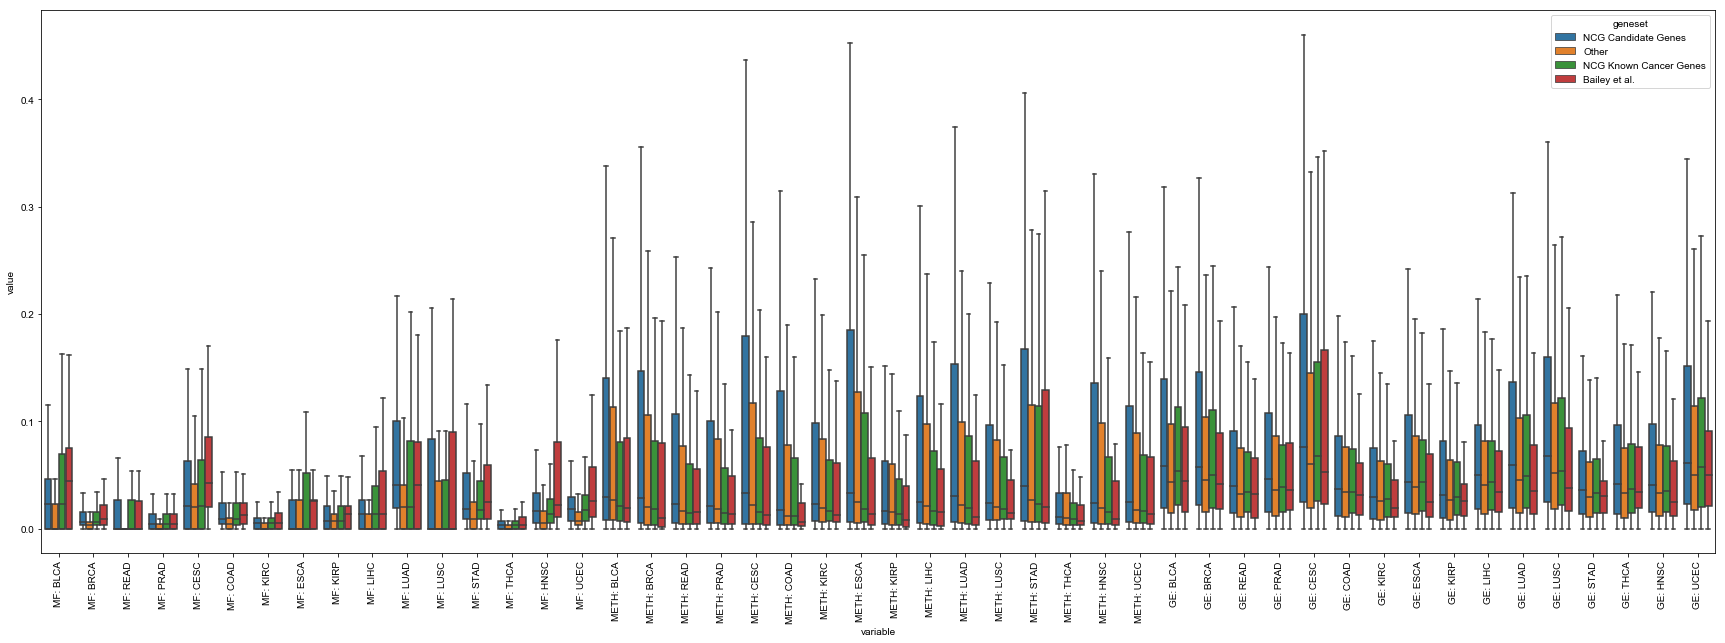

In [65]:
data = _get_training_data(os.path.join(dir_cpdb, 'multiomics'))
comprehensive, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(dir_cpdb, 'multiomics'))
network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
F = pd.DataFrame(features, index=node_names[:, 1], columns=feat_names)

# construct a feature df and melt it
F['geneset'] = 'Other'
F.loc[F.index.isin(ncg_cand), 'geneset'] = 'NCG Candidate Genes'
F.loc[F.index.isin(comprehensive), 'geneset'] = 'Bailey et al.'
F.loc[F.index.isin(ncg_known), 'geneset'] = 'NCG Known Cancer Genes'
x = F.melt(id_vars=['geneset'])

# plot
fig = plt.figure(figsize=(30, 10))
sns.boxplot(data=x, x='variable', y='value', hue='geneset', showfliers=False)
plt.xticks(rotation=90)

In [286]:
#clf = RandomForestClassifier(n_estimators=100)
clf = LogisticRegression()
X_train = features[train_mask.astype(np.bool)]
y_tr = y_train[train_mask.astype(np.bool)]
clf.fit(X_train, y_tr.reshape(-1))
predictions = clf.predict_proba(features)
predictions = pd.DataFrame(predictions[:, 1], index=node_names[:, 1], columns=['Mean_Pred'])
predictions['Name'] = predictions.index
predictions['label'] = y_test

cutoff = _get_optimal_cutoff(predictions, node_names, test_mask, y_test)
oncoKB, ncg_cand, ncg_known = get_cancer_genes_for_net(os.path.join(dir_cpdb, 'multiomics'))
oncokb_metric, ncg_cand_metric = _get_metric_score(predictions, node_names, ncg_known, ncg_cand, ['x'], cutoff, metric='aupr')

/home/sasse/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [287]:
ncg_cand_metric

0.10225208952129836

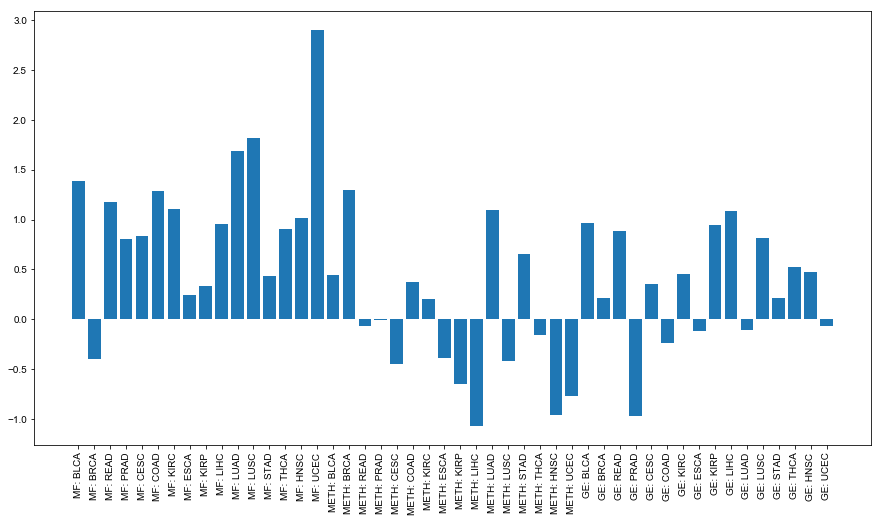

In [288]:
fig = plt.figure(figsize=(15, 8))
plt.bar(x=list(range(48)), height=clf.coef_.reshape(-1))
_ = plt.xticks(list(range(48)), labels=feat_names, rotation=90)

In [9]:
reference = 'multiomics'

degrees = []
for network_name in training_runs:
    print (network_name, training_runs[network_name])
    
    # get degrees for all genes in network
    train_dir = os.path.join(training_runs[network_name], reference)
    data = _get_training_data(train_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    n_df = pd.DataFrame(node_names, columns=['ID', 'Name'])
    n_df['Degree'] = network.sum(axis=1)
    n_df['Node_Type'] = 'Other'

    # collect DigSEE labels (pan-cancer labels)
    ds_expr_labels = []
    with open('../data/pancancer/digSEE/expression/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            ds_expr_labels.append(line.strip())
    n_df.loc[n_df.Name.isin(ds_expr_labels), 'Node_Type'] = 'DigSEE Expression\nGenes'
    ds_mut_labels = []
    with open('../data/pancancer/digSEE/mutation/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            ds_mut_labels.append(line.strip())
    n_df.loc[n_df.Name.isin(ds_mut_labels), 'Node_Type'] = 'DigSEE Mutation\nGenes'
    # add methylation literature evidence (digSEE)
    ds_meth_labels = []
    with open('../data/pancancer/digSEE/methylation/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            ds_meth_labels.append(line.strip())
    n_df.loc[n_df.Name.isin(ds_meth_labels), 'Node_Type'] = 'DigSEE Methylation\nGenes'

    # collect NCG labels (known cancer genes)
    ncg_labels = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                ncg_labels.append(l[0])
    n_df.loc[n_df.Name.isin(ncg_labels), 'Node_Type'] = 'NCG Known\nCancer Genes'
    n_df['Network'] = network_name
    degrees.append(n_df)

all_dfs = pd.concat(degrees, how='outer')
print(all_dfs[all_dfs.Node_Type != 'Other'].shape)
fig = plt.figure(figsize=(14, 10))
order = ['DigSEE Expression\nGenes', 'DigSEE Mutation\nGenes', 'DigSEE Methylation\nGenes', 'NCG Known\nCancer Genes', 'Other']
sns.boxplot(data=all_dfs, x='Network', y='Degree', hue='Node_Type', dodge=True, hue_order=order)
plt.ylabel('Node Degree', fontsize=20)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)
legend = plt.legend(prop={'size': 20}, handlelength=1)
plt.ylim([-30, 2000])

Multinet ../data/GCN/training/final_TCGA_all_networks/Multinet/
CPDB ../data/GCN/training/final_TCGA_all_networks/CPDB/
IREF ../data/GCN/training/final_TCGA_all_networks/IRefIndex_old/
STRING-db ../data/GCN/training/final_TCGA_all_networks/STRING-db/
IREF (New) ../data/GCN/training/final_TCGA_all_networks/IRefIndex/
PCNet ../data/GCN/training/final_TCGA_all_networks/PCNet/


TypeError: concat() got an unexpected keyword argument 'how'

In [ ]:
degrees[4].Degree.idxmax()
degrees[5].iloc[degrees[5].Degree.idxmax()]

In [ ]:
reference = 'multiomics'

degrees = {}
for network_name in training_runs:
    print (network_name, training_runs[network_name])
    
    # get degrees for all genes in network
    train_dir = os.path.join(training_runs[network_name], reference)
    data = _get_training_data(train_dir)
    network, features, y_train, y_val, y_test, train_mask, val_mask, test_mask, node_names, feat_names = data
    n_df = pd.DataFrame(node_names, columns=['ID', 'Name'])
    n_df['Degree'] = network.sum(axis=1)
    
    # collect DigSEE labels (pan-cancer labels)
    ds_expr_labels = []
    with open('../data/pancancer/digSEE/expression/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            ds_expr_labels.append(line.strip())
    ds_mut_labels = []
    with open('../data/pancancer/digSEE/mutation/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            ds_mut_labels.append(line.strip())
    # add methylation literature evidence (digSEE)
    ds_meth_labels = []
    with open('../data/pancancer/digSEE/methylation/pan_cancer_genes.txt', 'r') as f:
        for line in f.readlines():
            ds_meth_labels.append(line.strip())
    
    # collect NCG labels (known cancer genes)
    ncg_labels = []
    n = 0
    with open('../data/pancancer/NCG/cancergenes_list.txt', 'r') as f:
        for line in f.readlines():
            n += 1
            if n == 1:
                continue
            l = line.strip().split('\t')
            if len(l) == 2:
                ncg_labels.append(l[0])

    # compute degrees for label genes
    all_degrees = {}
    set_names = ['DigSee Expression\nGenes', 'DigSee Mutation\nGenes',
                 'DigSee Methylation\nGenes', 'NCG Known\nCancer Genes']
    i = 0
    for s in [ds_expr_labels, ds_mut_labels, ds_meth_labels, ncg_labels]:
        all_degrees[set_names[i]] = n_df[n_df.Name.isin(s)].Degree
        i += 1
    degrees[network_name] = all_degrees

all_df = []
for n in degrees:
    df_i = pd.DataFrame(degrees[n])
    df_i['Network'] = n
    all_df.append(df_i)
all_dfs = pd.concat(all_df).melt(id_vars=['Network'])
print (all_dfs.shape)
fig = plt.figure(figsize=(14, 10))
sns.boxplot(data=all_dfs, x='Network', y='value', hue='variable', dodge=True)
plt.ylabel('Node Degree', fontsize=20)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=16)
legend = plt.legend(prop={'size': 20}, handlelength=1)
plt.ylim([-30, 2000])

In [ ]:
perfect_points_x = []
perfect_points_y = []
onco, cand = get_cancer_genes_for_net('../data/GCN/training/all_multiomics_CPDB/multiomics/')
num_of_tests = len(onco)
for i in range(1, num_of_tests):
    pred = np.concatenate((np.ones(len(cand)), np.ones(i)))
    oncokb = np.concatenate((np.zeros(len(cand)), np.ones(i)))
    cand = np.concatenate((np.ones(len(cand)), np.zeros(i)))
    if metric_of_choice.upper() == 'RECALL':
        score_onco = recall_score(y_pred=pred, y_true=oncokb)
        score_cand = recall_score(y_pred=pred, y_true=cand)
    elif metric_of_choice.upper() == 'PRECISION':
        score_onco = precision_score(y_pred=pred, y_true=oncokb)
        score_cand = precision_score(y_pred=pred, y_true=cand)
    elif metric_of_choice.upper() == 'AUPR':
        score_onco = average_precision_score(y_score=pred, y_true=oncokb)
        score_cand = average_precision_score(y_score=pred, y_true=cand)
    else:
        print ("Metric not recognized")
    perfect_points_x.append(score_onco)
    perfect_points_y.append(score_cand)
    if i % (num_of_tests / 10) == 0:
        print ("Done with {} of {}".format(i, num_of_tests))
fig = plt.figure(figsize=(10, 10))
plt.scatter(perfect_points_x, perfect_points_y)

In [ ]:
training_runs = {'Final': '/project/gcn/diseasegcn/data/GCN/training/2019_07_23_17_26_39/multiomics/',
                 'NCG & DigSEE Labels (New Neg)': '/project/gcn/diseasegcn/data/GCN/training/2019_07_23_14_45_01/',
                 'Old Negatives': '/project/gcn/diseasegcn/data/GCN/training/2019_07_19_12_54_50/',
                 'SNV+CNA Standard':'/project/gcn/diseasegcn/data/GCN/training/all_multiomics_IREF_withCNA/multiomics/',
                 'Mutation Only': '../data/GCN/training/all_multiomics_IREF_withCNA/mutations/',
                 'Old Version': '../data/GCN/training/2018_12_04_16_38_36/'
                }

results = []
names = []
for run in training_runs:
    print (run)
    results.append(get_all_metrics_digsee(training_runs[run], metric=metric_of_choice))
    names.append(run)
    
res_df = pd.DataFrame(results, columns=['NCG Candidates', 'OncoKB Genes', 'DigSEE Mutation', 'DigSEE Methylation', 'DigSEE Expression'])
res_df['Method'] = names

fig = plt.figure(figsize=(14, 8))
#sns.barplot(x=['NCG Candidate Genes', 'OncoKB Genes', 'DigSEE Mutation Genes', 'DigSEE Methylation Genes', 'DigSEE Expression Genes'], y=metrics_for_run)
sns.barplot(data=res_df.melt(id_vars='Method'), x='variable', y='value', hue='Method')
plt.ylabel('{}'.format(metric_of_choice.upper()), fontsize=20)
plt.xlabel('', fontsize=20)
plt.xticks(fontsize=16)
plt.legend(fontsize=17)
#fig.savefig(os.path.join(training_dir, '{}_independent.svg'.format(metric_of_choice)))
res_df